# ========================================================================================
# JAX 1D-FDM + Position-Dependent hout(z) Optimization
# ========================================================================================
# 목적: hout을 위치(z)의 이차함수로 모델링하여 2개 파라미터 학습
# 
# 물리적 관찰:
#   - TC 데이터가 '위로 볼록' (중간이 더 뜨거움)
#   - hwi, hwo는 경계조건(z=0, z=L)이라 TC 위치에 영향 미미
#   - 따라서 hout이 위치에 따라 변해야 함
#
# hout 파라미터화:
#   hout(z) = h_min + h_amplitude * ((z - L/2) / (L/2))^2
#
# 의미:
#   - z=L/2 (중간): hout = h_min (최소 열손실) → T 높음
#   - z=0, L (끝): hout = h_min + h_amplitude (최대 열손실) → T 낮음
#   - 결과: T는 '위로 볼록' (∩), hout은 '아래로 볼록' (∪)
#
# 학습 파라미터:
#   - h_min: 중심에서의 최소 열전달계수
#   - h_amplitude: 끝단에서의 추가 열손실
#   - 케이스별 각 2개씩, 총 6개 파라미터
#
# 고정 파라미터:
#   - hwi = 1000.0
#   - hwo = 1000.0
# ========================================================================================

In [78]:
# 0) 라이브러리 로드
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import lax
from jax import custom_vjp
import optax

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")

JAX version: 0.8.2
JAX devices: [CudaDevice(id=0)]


In [79]:
# 1) 데이터 로드 및 설정
tc_pos = jnp.array(json.load(open('tc_pos.json')))
T_140 = jnp.array(json.load(open('Temp_profile_140W.json')))
T_280 = jnp.array(json.load(open('Temp_profile_280W.json')))
T_420 = jnp.array(json.load(open('Temp_profile_420W.json')))

powers = jnp.array([140.0, 280.0, 420.0])
T_meas_cases = jnp.array([T_140, T_280, T_420])
num_cases, n_TC = T_meas_cases.shape

print(f"Cases: {num_cases}, TC count: {n_TC}")

# 2) Geometry
L = 430e-3; ID = 5.03e-3; OD = 6.33e-3
Ai = jnp.pi * ID**2 / 4; Ao = jnp.pi * OD**2 / 4; Aw = Ao - Ai
pri = jnp.pi * ID; pro = jnp.pi * OD
dz = 0.001; n_nodes = int(L/dz) + 1; z = jnp.linspace(0, L, n_nodes)
Awg = pri * dz; Aout = pro * dz
tc_idx = jnp.array([jnp.argmin(jnp.abs(z - zp)) for zp in tc_pos])

print(f"Nodes: {n_nodes}, Grid: {dz*1000:.2f} mm")

# 3) Material properties
path_he = '../data/He_property.csv'
path_kt = '../data/KanthalD_property.csv'
df_he = pd.read_csv(path_he); df_kt = pd.read_csv(path_kt)
Mw_he = 4.0026

def rho_he(T): return 0.16352 * jnp.ones_like(T)
def cp_he(T): return 20.786 * jnp.ones_like(T)
def k_he(T): return 0.15531 * jnp.ones_like(T)
def rho_kt(T): return 7250 * jnp.ones_like(T)
def cp_kt(T): return 0.63 * 1000 * jnp.ones_like(T)
def k_kt(T): return 11 * jnp.ones_like(T)
def h_wg(Tg): return 4.36 * k_he(Tg) / ID

# 4) Feed conditions
P = 101325.0; Tamb = 25.0; Fv_std = 50.0
Fw = Fv_std * 1e-6 / 60 * rho_he(0)
F = Fw / Mw_he * 1000.0

print("Setup complete")

Cases: 3, TC count: 16
Nodes: 431, Grid: 1.00 mm
Setup complete


In [80]:
# 5) hout(z) 함수 정의

def compute_hout_profile(h_params, z_arr):
    """
    위치 z에 대한 hout(z) 프로파일 계산
    
    h_params: [c, m, k]
    """
    c, m, k = h_params[0], h_params[1], h_params[2]
    hout_profile = c + m/k*jnp.log(1+jnp.exp(k*(0.1 - z_arr))) + m/k*jnp.log(1+jnp.exp(k*(z_arr-0.33)))
    return hout_profile

print("hout(z) function defined")

hout(z) function defined


In [81]:
# 6) Residual function with position-dependent hout

HWI_FIXED = 0.
HWO_FIXED = 0.

def residual(U, h_params, Pw):
    """
    h_params: [c, m, k]
    hwi, hwo는 고정값 사용
    """
    hwi = HWI_FIXED
    hwo = HWO_FIXED
    
    # hout(z) 프로파일 계산
    hout_profile = compute_hout_profile(h_params, z)
    
    Tw = U[:n_nodes]; Tg = U[n_nodes:]
    kw = k_kt(Tw); cpg = cp_he(Tg); hwg = h_wg(Tg)
    Qelec = Pw * dz / L
    rw = jnp.zeros((n_nodes,)); rg = jnp.zeros((n_nodes,))
    
    # Wall BC
    rw = rw.at[0].set(hwi * Aw * (Tw[0] - Tamb) + kw[0] * Aw * (Tw[0] - Tw[1]) / dz)
    rw = rw.at[-1].set(hwo * Aw * (Tw[-1] - Tamb) + kw[-1] * Aw * (Tw[-1] - Tw[-2]) / dz)
    
    # Wall interior - hout은 위치별로 다름
    kw_half = 0.5 * (kw[1:] + kw[:-1])
    wflux = kw_half * Aw * (Tw[1:] - Tw[:-1]) / dz
    Qcond = (wflux[1:] - wflux[:-1]) / dz
    Qwg = hwg[1:-1] * Awg * (Tw[1:-1] - Tg[1:-1])
    Qout = hout_profile[1:-1] * Aout * (Tw[1:-1] - Tamb)  # 위치별 hout 사용
    rw = rw.at[1:-1].set(Qcond + (Qelec/dz) - (Qwg/dz) - (Qout/dz))
    
    # Gas BC & interior
    rg = rg.at[0].set(Tg[0] - Tw[0])
    rg = rg.at[-1].set(Tg[-1] - Tw[-1])
    gflux = F * cpg[1:-1] * (Tg[1:-1] - Tg[:-2]) / dz
    rg = rg.at[1:-1].set((Qwg/dz) - gflux)
    
    return jnp.concatenate([rw, rg])

# 7) Newton solver (forward only)
def newton_step(residual_fn, damping=1.0):
    def step(U, _):
        F = residual_fn(U)
        J = jax.jacfwd(residual_fn)(U)
        dU = jnp.linalg.solve(J, -F)
        U_new = U + damping * dU
        return U_new, (jnp.linalg.norm(F), jnp.linalg.norm(dU))
    return step

def newton_solve_forward(residual_fn, U0, iters=20, damping=1.0):
    step = newton_step(residual_fn, damping)
    U_final, (res_hist, step_hist) = lax.scan(step, U0, xs=None, length=iters)
    return U_final, res_hist, step_hist

print("Residual and Newton solver defined with position-dependent hout")

Residual and Newton solver defined with position-dependent hout


In [82]:
# 8) Implicit Differentiation Newton Solver
@custom_vjp
def newton_solve_implicit(h_params, Pw, U0, iters=20, damping=1.0):
    res_fn = lambda U: residual(U, h_params, Pw)
    U_final, _, _ = newton_solve_forward(res_fn, U0, iters, damping)
    return U_final

def newton_solve_implicit_fwd(h_params, Pw, U0, iters, damping):
    U_star = newton_solve_implicit(h_params, Pw, U0, iters, damping)
    return U_star, (h_params, Pw, U_star)

def newton_solve_implicit_bwd(res, g):
    h_params, Pw, U_star = res
    res_fn = lambda U: residual(U, h_params, Pw)
    J = jax.jacfwd(res_fn)(U_star)
    lmbda = jnp.linalg.solve(J.T, g)
    
    def res_wrt_h_params(hp):
        return residual(U_star, hp, Pw)
    _, vjp_h_params = jax.vjp(res_wrt_h_params, h_params)
    grad_h_params = vjp_h_params(-lmbda)[0]
    
    def res_wrt_Pw(p):
        return residual(U_star, h_params, p)
    _, vjp_Pw = jax.vjp(res_wrt_Pw, Pw)
    grad_Pw = vjp_Pw(-lmbda)[0]
    
    grad_U0 = jnp.zeros_like(U_star)
    return (grad_h_params, grad_Pw, grad_U0, None, None)

newton_solve_implicit.defvjp(newton_solve_implicit_fwd, newton_solve_implicit_bwd)

print("Implicit differentiation solver ready")

Implicit differentiation solver ready


## hout(z) 파라미터 학습: c, m, k, z1, z2

In [83]:
# 9) Fitting setup - hout(z) 파라미터 학습

LEARNING_RATE = 1e0

def h_params_phys(h_params_raw):
    """
    h_params_raw를 물리적으로 유효한 h_params로 변환
    h_params = [c, m, k]
    """
    eps = 1e-6
    h_params = jax.nn.softplus(h_params_raw) + eps
    # c: [0, 100], m: [0, 100], k: [1, 10]
    c = jnp.clip(h_params[0], 0., 100.0)
    m = jnp.clip(h_params[1], 10., 250.0)
    k = jnp.clip(h_params[2], 10, 200)

    return jnp.array([c, m, k])

def softplus_inv(h):
    return jnp.log(jnp.exp(h) - 1.0)

# 초기값: a = 1, b = 3, c = 40 (케이스별)
h_params_init = jnp.array([
    [24., 200., 50.],  # Case 1: [c, m, k]
    [41., 200., 50.],  # Case 2
    [47., 200., 50.]   # Case 3
])
h_params_raw = jax.vmap(softplus_inv)(h_params_init)  # (3, 2)

# 초기 상태
Tw0 = Tamb * jnp.ones(n_nodes)
Tg0 = Tamb * jnp.ones(n_nodes)
U0 = jnp.concatenate([Tw0, Tg0])
U0_cases = jnp.stack([U0, U0, U0])

def predict_TC(U):
    return U[:n_nodes][tc_idx]

def case_loss(h_params, Pw, U0, T_meas):
    """단일 케이스 손실함수"""
    U_star = newton_solve_implicit(h_params, Pw, U0, iters=20, damping=1.0)
    T_pred = predict_TC(U_star)
    loss = jnp.mean((T_pred - T_meas)**2)
    return loss, U_star

def total_loss(h_params_raw, U0_cases, T_meas_cases, powers):
    """전체 손실함수 (3개 케이스)"""
    h_params = jax.vmap(h_params_phys)(h_params_raw)  # (3, 2)
    
    def one_case(hp_k, U0_k, T_k, Pw_k):
        loss_k, _ = case_loss(hp_k, Pw_k, U0_k, T_k)
        return loss_k
    
    losses = jax.vmap(one_case)(h_params, U0_cases, T_meas_cases, powers)
    return jnp.sum(losses)

def warm_start_update(h_params_raw, U0_cases, T_meas_cases, powers):
    """Warm-start 업데이트"""
    h_params = jax.vmap(h_params_phys)(h_params_raw)
    
    def one_case(hp_k, U0_k, T_k, Pw_k):
        _, U_star = case_loss(hp_k, Pw_k, U0_k, T_k)
        return lax.stop_gradient(U_star)
    
    return jax.vmap(one_case)(h_params, U0_cases, T_meas_cases, powers)

def get_newton_convergence(h_params_raw, U0_cases, T_meas_cases, powers):
    """Newton 수렴성 진단"""
    h_params = jax.vmap(h_params_phys)(h_params_raw)
    
    def one_case(hp_k, U0_k, T_k, Pw_k):
        res_fn = lambda U: residual(U, hp_k, Pw_k)
        _, res_hist, step_hist = newton_solve_forward(res_fn, U0_k, iters=20, damping=1.0)
        return res_hist[-1], step_hist[-1]
    
    res_norms, step_norms = jax.vmap(one_case)(h_params, U0_cases, T_meas_cases, powers)
    return res_norms, step_norms

print("="*80)
print("Fitting Setup - Position-Dependent hout(z)")
print("="*80)
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"  - hout(z) = c + m/k*ln(1+exp(k*(0.1-z))) + m/k*ln(1+exp(k*(z-0.33)))")
print(f"  - c 범위: [0.0, 100.0]")
print(f"  - m 범위: [0.0, 100.0]")
print(f"  - k 범위: [1.0, 10]")
print(f"  - 학습 파라미터 수: {num_cases} cases × 3 params = {num_cases * 3}")
print("="*80)

Fitting Setup - Position-Dependent hout(z)
  - Learning rate: 1.0
  - hout(z) = c + m/k*ln(1+exp(k*(0.1-z))) + m/k*ln(1+exp(k*(z-0.33)))
  - c 범위: [0.0, 100.0]
  - m 범위: [0.0, 100.0]
  - k 범위: [1.0, 10]
  - 학습 파라미터 수: 3 cases × 3 params = 9


In [84]:
# 10) Training loop
opt = optax.adam(learning_rate=LEARNING_RATE)
opt_state = opt.init(h_params_raw)
loss_and_grad = jax.value_and_grad(total_loss)

print("="*80)
print("TRAINING START: hout(z) 파라미터 학습")
print("="*80)
print(f"Learning rate: {LEARNING_RATE}")
print(f"Epochs: 100")
print("="*80)

history = {
    'loss': [],
    'c': [],
    'm': [],
    'k': [],
    'grads': [],
    'newton_res': [],
    'newton_step': []
}

for step in range(100):
    loss, grads = loss_and_grad(h_params_raw, U0_cases, T_meas_cases, powers)
    updates, opt_state = opt.update(grads, opt_state)
    h_params_raw = optax.apply_updates(h_params_raw, updates)
    
    res_norms, step_norms = get_newton_convergence(h_params_raw, U0_cases, T_meas_cases, powers)
    U0_cases = warm_start_update(h_params_raw, U0_cases, T_meas_cases, powers)
    
    h_params = jax.vmap(h_params_phys)(h_params_raw)  # (3, 2)
    history['loss'].append(float(loss))
    history['c'].append(np.array(h_params[:, 0]))
    history['m'].append(np.array(h_params[:, 1]))
    history['k'].append(np.array(h_params[:, 2]))
    history['grads'].append(np.array(grads))
    history['newton_res'].append(np.array(res_norms))
    history['newton_step'].append(np.array(step_norms))
    
    # 매 20 epoch마다 출력
    if step % 20 == 0 or step < 5:
        print(f'\nEPOCH {step:04d} | Loss = {float(loss):.6e}')
        for k, Pw_k in enumerate([140., 280., 420.]):
            c_k = float(h_params[k, 0])
            m_k = float(h_params[k, 1])
            k_k = float(h_params[k, 2])
            grad_c = float(grads[k, 0])
            grad_m = float(grads[k, 1])
            grad_k = float(grads[k, 2])
            print(f'  Case {k+1} ({Pw_k}W): c={c_k:.3f}, m={m_k:.3f}, k={k_k:.3f}')
            print(f'    ∇c={grad_c:.3e}, ∇m={grad_m:.3e}, ∇k={grad_k:.3e}, ||F||={float(res_norms[k]):.2e}')

print(f'\n{"="*80}')
print("TRAINING COMPLETE")
print(f'{"="*80}')

TRAINING START: hout(z) 파라미터 학습
Learning rate: 1.0
Epochs: 100

EPOCH 0000 | Loss = 5.460283e+03
  Case 1 (140.0W): c=25.000, m=250.000, k=49.000
    ∇c=-8.878e+02, ∇m=0.000e+00, ∇k=1.942e+01, ||F||=1.04e-01
  Case 2 (280.0W): c=42.000, m=250.000, k=49.000
    ∇c=-7.566e+02, ∇m=0.000e+00, ∇k=2.166e+01, ||F||=1.19e-01
  Case 3 (420.0W): c=48.000, m=250.000, k=49.000
    ∇c=-1.309e+03, ∇m=0.000e+00, ∇k=3.866e+01, ||F||=1.68e-01

EPOCH 0001 | Loss = 3.529309e+03
  Case 1 (140.0W): c=25.688, m=250.000, k=48.732
    ∇c=-2.175e+01, ∇m=0.000e+00, ∇k=-9.680e+00, ||F||=9.62e-02
  Case 2 (280.0W): c=42.868, m=250.000, k=48.203
    ∇c=-2.479e+02, ∇m=0.000e+00, ∇k=4.107e+00, ||F||=1.16e-01
  Case 3 (420.0W): c=48.921, m=250.000, k=48.108
    ∇c=-6.072e+02, ∇m=0.000e+00, ∇k=1.481e+01, ||F||=1.51e-01

EPOCH 0002 | Loss = 3.357718e+03
  Case 1 (140.0W): c=25.864, m=250.000, k=49.101
    ∇c=4.625e+02, ∇m=0.000e+00, ∇k=-2.701e+01, ||F||=1.06e-01
  Case 2 (280.0W): c=43.418, m=250.000, k=47.930
    ∇c=1

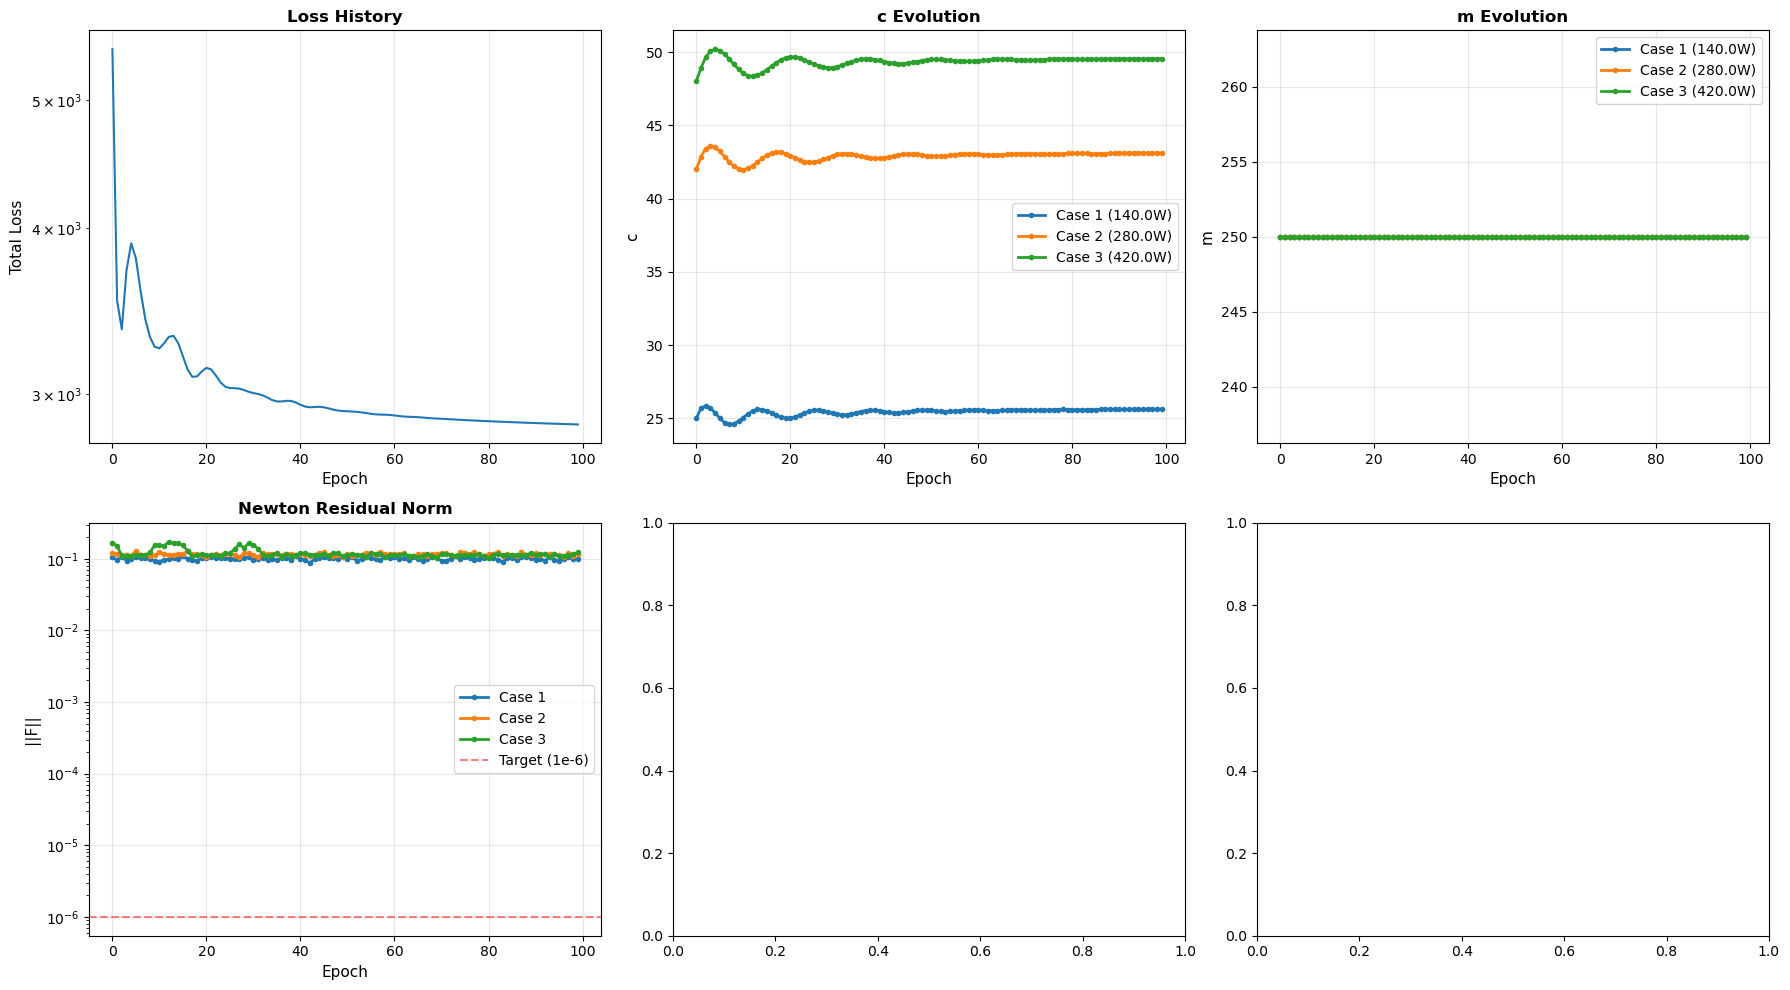

In [85]:
# 11) Visualization - 모든 파라미터(c, m, k, hwi, hwo)의 evolution을 개별적으로 표시
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss history
axes[0, 0].semilogy(history['loss'])
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Total Loss', fontsize=11)
axes[0, 0].set_title('Loss History', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# c, m, k, hwi, hwo evolution
param_names = ['c', 'm', 'k']
history_arrays = [np.array(history['c']), np.array(history['m']), np.array(history['k'])]

# 0,1: c evolution / 0,2: m evolution / 1,0: k evolution / 1,1: hwi / 1,2: hwo
plot_map = {(0,1): ('c', 0), (0,2): ('m', 1), (1,0): ('k', 2)}

for (i, j), (label, idx) in plot_map.items():
    arr = history_arrays[idx]
    for k in range(3):
        axes[i, j].plot(arr[:, k], label=f'Case {k+1} ({powers[k]}W)', 
                        marker='o', markersize=3, linewidth=2)
    axes[i, j].set_xlabel('Epoch', fontsize=11)
    axes[i, j].set_ylabel(label, fontsize=11)
    axes[i, j].set_title(f'{label} Evolution', fontsize=12, fontweight='bold')
    axes[i, j].legend(fontsize=10)
    axes[i, j].grid(True, alpha=0.3)

# Newton convergence는 loss history와 parameter evolution 사이에 그대로 둠
# (loss, c, m)
# (k, hwi, hwo)

# Newton convergence를 loss아래에 그대로 표시
newton_res = np.array(history['newton_res'])
axes[1, 0].clear()  # 혹시 k와 겹치는 부분 clear
for k in range(3):
    axes[1, 0].semilogy(newton_res[:, k], label=f'Case {k+1}', 
                        marker='o', markersize=3, linewidth=2)
axes[1, 0].axhline(1e-6, color='r', linestyle='--', alpha=0.5, label='Target (1e-6)')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('||F||', fontsize=11)
axes[1, 0].set_title('Newton Residual Norm', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


FINAL RESULTS - Position-Dependent hout(z)

케이스 1 (140.0W):
  c:   25.630
  m:   250.000
  k:   85.100
  hout(z=0):            50.631
  hout(z=L/2):          25.630
  hout(z=L):            50.631
  Newton:               ||F||=9.863e-02
  TC MSE:               9.678e+02


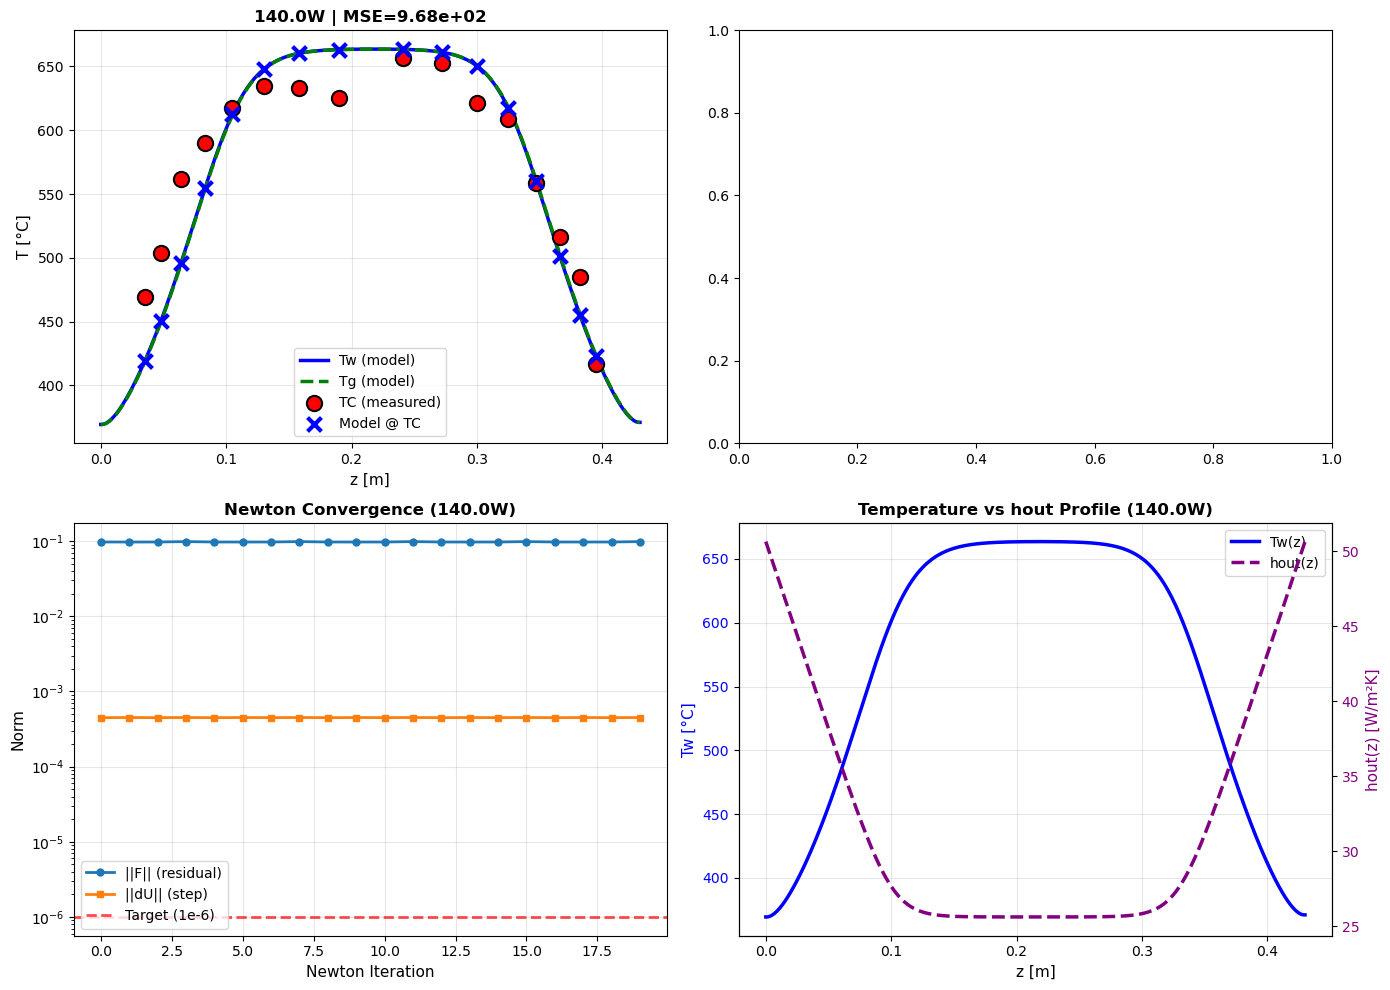


케이스 2 (280.0W):
  c:   43.107
  m:   250.000
  k:   75.967
  hout(z=0):            68.109
  hout(z=L/2):          43.108
  hout(z=L):            68.109
  Newton:               ||F||=1.168e-01
  TC MSE:               7.496e+02


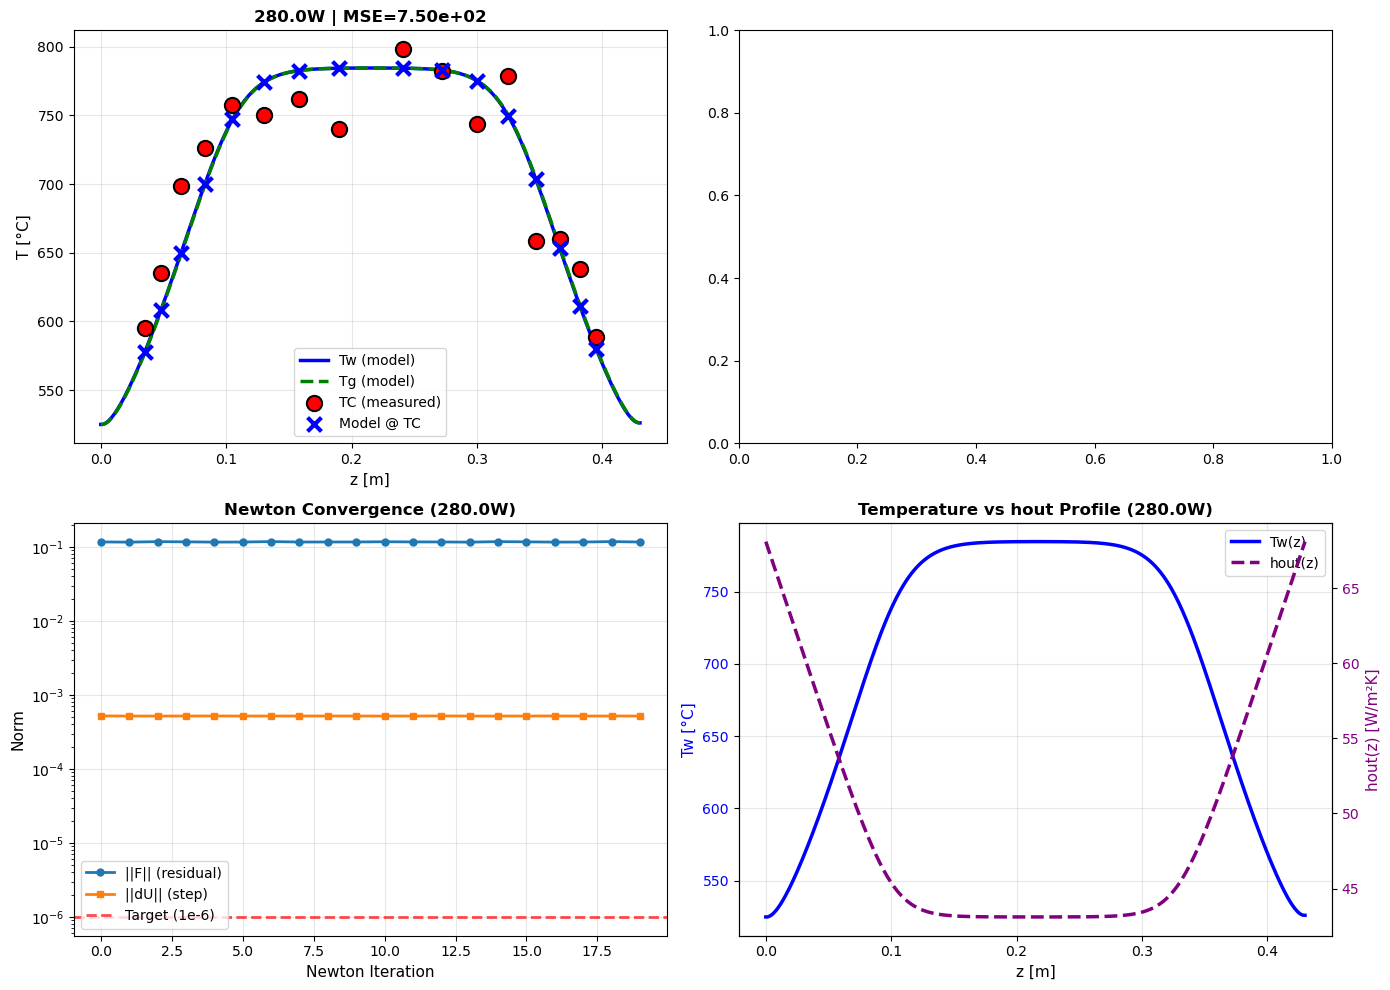


케이스 3 (420.0W):
  c:   49.556
  m:   250.000
  k:   75.846
  hout(z=0):            74.558
  hout(z=L/2):          49.557
  hout(z=L):            74.558
  Newton:               ||F||=1.128e-01
  TC MSE:               1.128e+03


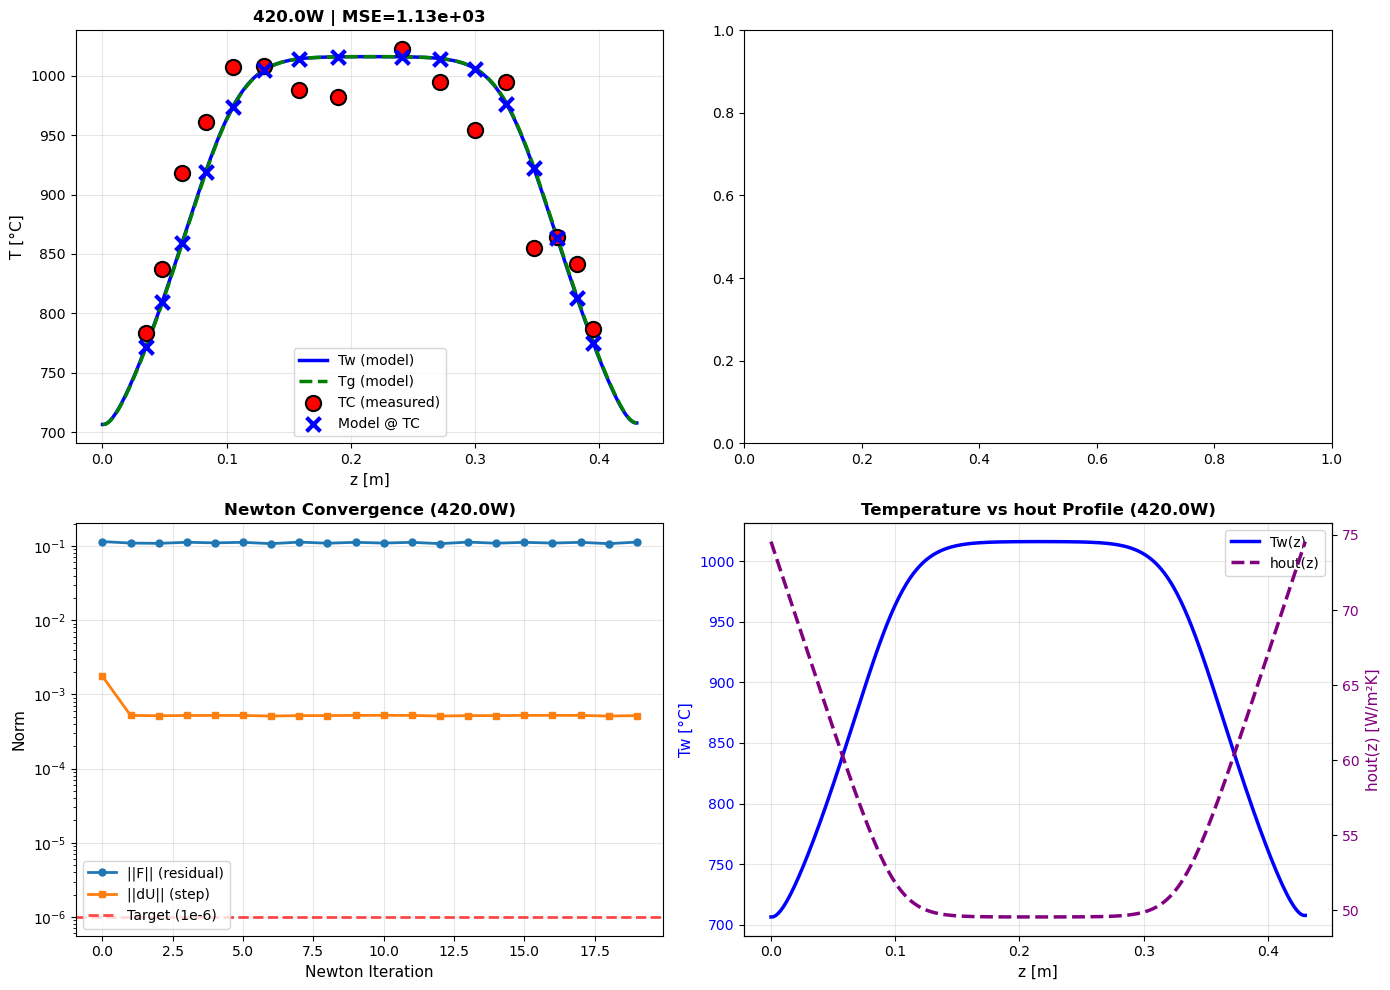

In [86]:
# 12) Final results with hout(z) profile visualization
h_params_final = jax.vmap(h_params_phys)(h_params_raw)

print("\n" + "="*80)
print("FINAL RESULTS - Position-Dependent hout(z)")
print("="*80)

for k, Pw_k in enumerate([140., 280., 420.]):
    c_k = float(h_params_final[k, 0])
    m_k = float(h_params_final[k, 1])
    k_k = float(h_params_final[k, 2])
    hp_k = h_params_final[k]
    
    # hout(z) 프로파일 계산
    hout_profile = compute_hout_profile(hp_k, z)
    
    res_fn = lambda U: residual(U, hp_k, Pw_k)
    U_star, res_hist, step_hist = newton_solve_forward(res_fn, U0_cases[k], iters=20, damping=1.0)
    Tw = U_star[:n_nodes]; Tg = U_star[n_nodes:]
    Tw_tc = predict_TC(U_star)
    mse = float(jnp.mean((Tw_tc - T_meas_cases[k])**2))
    
    print(f"\n케이스 {k+1} ({Pw_k}W):")
    print(f"  c:   {c_k:.3f}")
    print(f"  m:   {m_k:.3f}")
    print(f"  k:   {k_k:.3f}")
    print(f"  hout(z=0):            {float(hout_profile[0]):.3f}")
    print(f"  hout(z=L/2):          {float(hout_profile[n_nodes//2]):.3f}")
    print(f"  hout(z=L):            {float(hout_profile[-1]):.3f}")
    print(f"  Newton:               ||F||={float(res_hist[-1]):.3e}")
    print(f"  TC MSE:               {mse:.3e}")
    
    # Temperature and hout profile
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Temperature profile
    axes[0, 0].plot(np.array(z), np.array(Tw), label='Tw (model)', linewidth=2.5, color='blue')
    axes[0, 0].plot(np.array(z), np.array(Tg), label='Tg (model)', linewidth=2.5, 
                    linestyle='--', color='green')
    axes[0, 0].scatter(np.array(tc_pos), np.array(T_meas_cases[k]), s=120, c='red', 
                       label='TC (measured)', zorder=5, edgecolors='black', linewidths=1.5)
    axes[0, 0].scatter(np.array(tc_pos), np.array(Tw_tc), s=100, c='blue', marker='x', 
                       linewidths=3, label='Model @ TC', zorder=5)
    axes[0, 0].set_title(f'{Pw_k}W | MSE={mse:.2e}', fontsize=12, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].set_xlabel('z [m]', fontsize=11)
    axes[0, 0].set_ylabel('T [°C]', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)
    
       
    # Newton convergence
    axes[1, 0].semilogy(np.array(res_hist), label='||F|| (residual)', marker='o', 
                        markersize=5, linewidth=2)
    axes[1, 0].semilogy(np.array(step_hist), label='||dU|| (step)', marker='s', 
                        markersize=5, linewidth=2)
    axes[1, 0].axhline(1e-6, color='r', linestyle='--', alpha=0.7, linewidth=2, label='Target (1e-6)')
    axes[1, 0].set_title(f'Newton Convergence ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].set_xlabel('Newton Iteration', fontsize=11)
    axes[1, 0].set_ylabel('Norm', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)
    
    # T vs hout correlation
    axes[1, 1].plot(np.array(z), np.array(Tw), label='Tw(z)', linewidth=2.5, color='blue')
    ax2 = axes[1, 1].twinx()
    ax2.plot(np.array(z), np.array(hout_profile), label='hout(z)', linewidth=2.5, 
             color='purple', linestyle='--')
    axes[1, 1].set_xlabel('z [m]', fontsize=11)
    axes[1, 1].set_ylabel('Tw [°C]', fontsize=11, color='blue')
    ax2.set_ylabel('hout(z) [W/m²K]', fontsize=11, color='purple')
    axes[1, 1].set_title(f'Temperature vs hout Profile ({Pw_k}W)', fontsize=12, fontweight='bold')
    axes[1, 1].tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='purple')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add legend for both axes
    lines1, labels1 = axes[1, 1].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    axes[1, 1].legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=10)
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)

In [87]:
# 13) Summary
print("\n" + "="*80)
print("Position-Dependent hout(z) 최적화 요약")
print("="*80)

print("\n1. 학습 설정:")
print(f"   - 학습 파라미터: h_min, h_amplitude (케이스별 2개씩, 총 6개)")
print(f"   - 고정 파라미터: hwi={HWI_FIXED}, hwo={HWO_FIXED}")
print(f"   - Learning rate: {LEARNING_RATE}")
print(f"   - hout(z) = h_min + h_amplitude * ((z - L/2) / (L/2))^2")

print("\n2. 학습 성능:")
loss_reduction = (1 - history['loss'][-1]/history['loss'][0]) * 100
print(f"   - Initial loss: {history['loss'][0]:.6e}")
print(f"   - Final loss:   {history['loss'][-1]:.6e}")
print(f"   - Reduction:    {loss_reduction:.2f}%")

print("\n3. 최적화된 hout(z) 파라미터:")
for k in range(3):
    h_min_k = float(h_params_final[k, 0])
    h_amp_k = float(h_params_final[k, 1])
    hout_center = h_min_k
    hout_edge = h_min_k + h_amp_k
    print(f"   Case {k+1} ({powers[k]}W):")
    print(f"     h_min = {h_min_k:.3f} (중심 z=L/2)")
    print(f"     h_amplitude = {h_amp_k:.3f}")
    print(f"     → hout(center) = {hout_center:.3f}")
    print(f"     → hout(edge) = {hout_edge:.3f}")
    print(f"     → 변화율: {(hout_edge/hout_center - 1)*100:.1f}%")

print("\n4. Gradient 상태:")
final_grads = history['grads'][-1]
for k in range(3):
    grad_min = abs(final_grads[k, 0])
    grad_amp = abs(final_grads[k, 1])
    status_min = "✅ 정상" if grad_min > 1e-10 else "⚠️  약함" if grad_min > 1e-15 else "❌ 소실"
    status_amp = "✅ 정상" if grad_amp > 1e-10 else "⚠️  약함" if grad_amp > 1e-15 else "❌ 소실"
    print(f"   Case {k+1}:")
    print(f"     |∇h_min| = {grad_min:.3e} {status_min}")
    print(f"     |∇h_amplitude| = {grad_amp:.3e} {status_amp}")

print("\n5. 물리적 해석:")
print("   - hout(z)이 '아래로 볼록' (∪) 형태 → 중간이 최소, 끝단이 최대")
print("   - 결과: T(z)가 '위로 볼록' (∩) 형태 → 중간이 최고온, 끝단이 저온")
print("   - 물리적 의미: 끝단에서 추가 열손실 메커니즘 존재")
print("     (복사, 전도, 기하학적 효과 등)")

print("\n" + "="*80)
print("결론:")
print("="*80)

if loss_reduction > 50:
    print("✅ Position-dependent hout(z) 최적화가 성공적입니다!")
    print(f"   - 전체 손실 감소: {loss_reduction:.1f}%")
    print("   - hout(z) 파라미터화가 물리적으로 타당함")
    print("   - 온도 프로파일의 '위로 볼록' 패턴을 성공적으로 재현")
    
    if all(abs(final_grads[k, 0]) > 1e-10 and abs(final_grads[k, 1]) > 1e-10 for k in range(3)):
        print("\n✅ 모든 파라미터에서 gradient가 정상적으로 흐릅니다.")
        print("   → 2-파라미터 hout(z) 모델이 효과적입니다.")
    
    print("\n💡 다음 단계 제안:")
    print("   - 온도 의존 hout(T) 모델과 비교")
    print("   - 더 복잡한 형태 시도 (Gaussian, cubic 등)")
    print("   - 물리적 해석: 끝단 열손실 메커니즘 규명")
else:
    print("⚠️  추가 개선이 필요합니다.")
    print(f"   현재 손실 감소: {loss_reduction:.1f}%")
    print("   → Learning rate 조정")
    print("   → epoch 수 증가")
    print("   → 초기값 변경")

print("\n" + "="*80)


Position-Dependent hout(z) 최적화 요약

1. 학습 설정:
   - 학습 파라미터: h_min, h_amplitude (케이스별 2개씩, 총 6개)
   - 고정 파라미터: hwi=0.0, hwo=0.0
   - Learning rate: 1.0
   - hout(z) = h_min + h_amplitude * ((z - L/2) / (L/2))^2

2. 학습 성능:
   - Initial loss: 5.460283e+03
   - Final loss:   2.846354e+03
   - Reduction:    47.87%

3. 최적화된 hout(z) 파라미터:
   Case 1 (140.0W):
     h_min = 25.630 (중심 z=L/2)
     h_amplitude = 250.000
     → hout(center) = 25.630
     → hout(edge) = 275.630
     → 변화율: 975.4%
   Case 2 (280.0W):
     h_min = 43.107 (중심 z=L/2)
     h_amplitude = 250.000
     → hout(center) = 43.107
     → hout(edge) = 293.107
     → 변화율: 580.0%
   Case 3 (420.0W):
     h_min = 49.556 (중심 z=L/2)
     h_amplitude = 250.000
     → hout(center) = 49.556
     → hout(edge) = 299.556
     → 변화율: 504.5%

4. Gradient 상태:
   Case 1:
     |∇h_min| = 1.433e+00 ✅ 정상
     |∇h_amplitude| = 0.000e+00 ❌ 소실
   Case 2:
     |∇h_min| = 3.097e+00 ✅ 정상
     |∇h_amplitude| = 0.000e+00 ❌ 소실
   Case 3:
     |∇h_min| = 3.